hello !!

objective : to make a prediction model for quora sincere questions

dataset link : https://www.kaggle.com/c/quora-insincere-questions-classification/data

### General Description

In this project we will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

1    Has a non-neutral tone
     
     1.1   Has an exaggerated tone to underscore a point about a group of people
     
     1.2   Is rhetorical and meant to imply a statement about a group of people

2    Is disparaging or inflammatory
     
     2.1   Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a    
           stereotype
     
     2.2   Makes disparaging attacks/insults against a specific person or group of people
     
     2.3   Based on an outlandish premise about a group of people
     
     2.4   Disparages against a characteristic that is not fixable and not measurable 

3    Isn't grounded in reality
     
     3.1   Based on false information, or contains absurd assumptions

4    Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers


### Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import string
import sys
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,f1_score
pd.options.mode.chained_assignment = None


### read data

In [35]:
# reading data from file
df = pd.read_csv('./data/train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [36]:
df.shape
# approx 13 lakhs data points

(1306122, 3)

In [37]:
#dropping qid col
df=df.drop('qid',axis=1)
df.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


### class imbalance

In [38]:
# class distribution
class_dist=df['target'].value_counts(normalize=True)*100
class_dist

0   93.813
1    6.187
Name: target, dtype: float64

### splitting data into train/test/val

In [39]:
# splitting dataset into train/val/test
df_train,df_test_val=train_test_split(df,test_size=0.20,random_state=42)
df_test,df_val=train_test_split(df_test_val,test_size=0.5,random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

### data sanity

In [40]:
# lets see some of the random questions which are not sincere
insincere_sent=df_train['question_text'].loc[df_train['target']==1].sample(n=5,random_state=42)
k=1
for i in insincere_sent:
    print(k,'> '+i)
    k+=1
    

1 > Do you think it is right for the Australian government to introduce cashless welfare in some regional areas of Australia to prevent Australian Aboriginals from using welfare cash for grog, drugs and gambling expenses?
2 > Help my dick got stuck in the hole of my DVD?
3 > What is left of the libturd party? They've been wiped off the map virtually everywhere and they're flat broke to-boot. What colossal losers?
4 > Why do people je*k off when they see bad news about China?
5 > Why does caucasians sound like cock Asians?


In [41]:
# lets see some of the random questions which are sincere
sincere_sent=df_train['question_text'].loc[df_train['target']==0].sample(n=5,random_state=42)
k=1
for i in sincere_sent:
    print(k,'> '+i)
    k+=1

1 > Why am I unable to downvote some answers on Quora?
2 > Why did you follow me on Quora exactly?
3 > Will a borderline personality follow the idealization, devalue, discard cycle that a narcissist does?
4 > What is the best way to score good marks in CBSE class 10?
5 > How do I know what is the right temperature for my celery to grow healthy?


### wordclouds

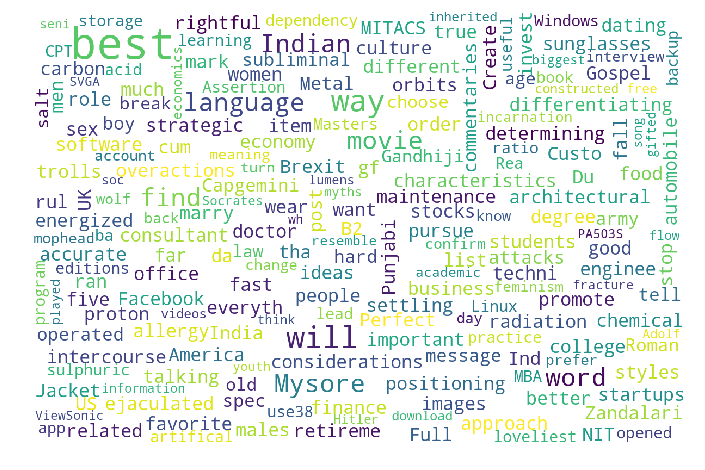

In [42]:
#word cloud of sincere questions
stopwords = set(STOPWORDS)
wordcloud = WordCloud(    width = 1200, height = 800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate( str(df_train['question_text'].loc[df_train['target']==0]) )
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

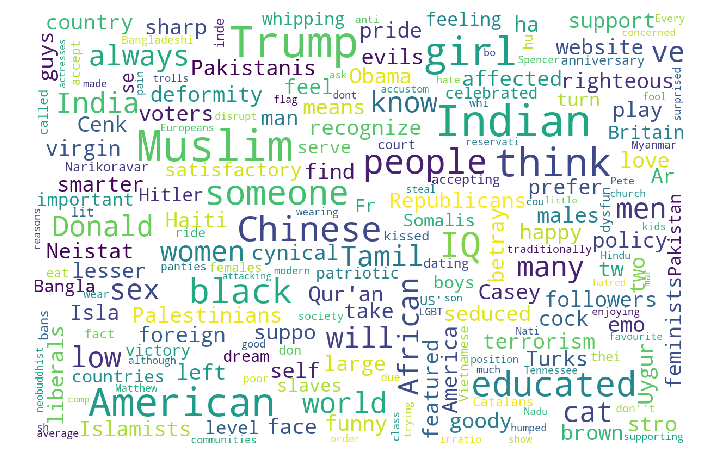

In [43]:
#word cloud of in-sincere questions
wordcloud = WordCloud(    width = 1200, height = 800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate( str(df_train['question_text'].loc[df_train['target']==1]) )
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### data preprocessing

In [44]:
# functions for data preprocessing

from nltk.corpus import stopwords
stop = stopwords.words('english')

def remove_puntuation(text):
    for c in string.punctuation:
        text= text.replace(c,"")
    return text

def lower_strip(text):
    return text.lower().strip()

def remove_digits(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop])

def clean_text(text):
    return remove_stopwords(remove_puntuation(remove_digits(lower_strip(text))))

In [45]:
df_train['len_raw'] = df_train['question_text'].apply(lambda x:len(x.split()))
df_train['question_text']=df_train['question_text'].apply(clean_text)
df_val['question_text']=df_val['question_text'].apply(clean_text)
df_test['raw_question_text']=df_test['question_text']
df_test['question_text']=df_test['question_text'].apply(clean_text)

In [46]:
# building vocab of words and thier occurances
sentences = df_train['question_text'].apply(lambda x: x.split()).values
vocab = {}
for sentence in sentences:
    for word in sentence:
        try:
            vocab[word] += 1
        except KeyError:
            vocab[word] = 1
    

### analyzing sentence lengths

In [47]:
# analysis of len of questions before preprocessing 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train['len_raw'].describe()

count   1044897.000
mean         12.803
std           7.048
min           1.000
25%           8.000
50%          11.000
75%          15.000
max         134.000
Name: len_raw, dtype: float64

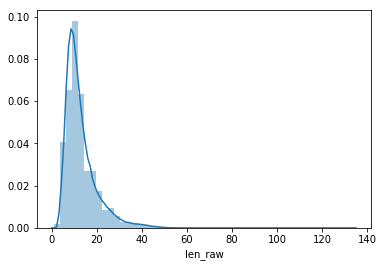

In [48]:
sns.distplot(df_train['len_raw'])

In [49]:
# analysis of len of questions after preprocessing 
df_train['len_clean'] = df_train['question_text'].apply(lambda x:len(x.split()))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train['len_clean'].describe()

count   1044897.000
mean          6.406
std           3.644
min           0.000
25%           4.000
50%           5.000
75%           8.000
max          69.000
Name: len_clean, dtype: float64

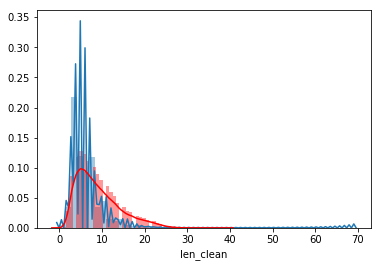

In [50]:
sns.distplot(df_train['len_clean'].loc[df_train['target']==0],label='class0')
sns.distplot(df_train['len_clean'].loc[df_train['target']==1],color='red',label='class1')

In [51]:
# sentences with len greater than 30 
len(df_train.loc[df_train['len_clean']>30])

# less sentences so we will only use padding len of 30 

16

### create word embeddings

In [52]:
# loading google news vectors

from gensim.models import KeyedVectors
filepath='./data/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filepath, binary=True) 

/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [53]:
# analsis of text presence in google news vectors
total_sum=0
in_vect=0 # for calculating vocab presence
tot_in_vect=0 # for calculating total_text presence
words_not_present=[]
words_present_freq=[]
words_not_present_freq=[]

for i in vocab:
    if i in model:
        in_vect+=1
        total_sum+=vocab[i]
        tot_in_vect+=vocab[i]
        words_present_freq.append(vocab[i])
        
    else:
        
        total_sum+=vocab[i]
        words_not_present.append(i)
        words_not_present_freq.append(vocab[i])

print('words present of vocab: ',(in_vect/len(vocab))*100)
print('words present of total text: ',(tot_in_vect/total_sum)*100)

words present of vocab:  35.209288173902124
words present of total text:  94.30073682453829


In [54]:
max_freq=20
max_freq_word=[]
for i in words_not_present:
    if ((vocab[i]>max_freq) and (i not in stop)):
        max_freq_word.append(i)
print (len(max_freq_word),len(words_not_present))

1701 134155


In [55]:
max_freq_word[0:20]

['doesnt',
 'instagram',
 'bezos',
 'elon',
 'didn’t',
 '₹',
 'mysore',
 'uks',
 'brexit',
 'dunkirk',
 'quora',
 'upvote',
 'bhutan',
 'comedk',
 'himher',
 'crispr',
 'i’m',
 'btech',
 'aiims',
 'sgsits']

### converting text data to vectors 

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df_train['question_text'],df_test['question_text'],df_val['question_text']]))

In [58]:
sequences_train = tokenizer.texts_to_sequences(df_train['question_text'])
sequences_test = tokenizer.texts_to_sequences(df_test['question_text'])
sequences_val = tokenizer.texts_to_sequences(df_val['question_text'])

train_X = pad_sequences(sequences_train,maxlen=30)
test_X = pad_sequences(sequences_test,maxlen=30)
val_X = pad_sequences(sequences_val,maxlen=30)

In [59]:
train_Y=np.array(df_train['target']).reshape(-1,1)
test_Y=np.array(df_test['target']).reshape(-1,1)
val_Y=np.array(df_val['target']).reshape(-1,1)

In [60]:
# making embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_counts)+1,300))
for word, index in tokenizer.word_index.items():
    if word in model:
        embedding_matrix[index] = model[word]
print('size of embedding matrix: ',len(embedding_matrix))

size of embedding matrix:  236459


### model building/training

In [61]:
from keras.layers import Dense, Embedding ,Convolution1D, Masking
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN
from keras import regularizers
import utils

In [62]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_counts)+1,300,input_length=30,weights=[embedding_matrix],trainable=False))
model.add(Masking(mask_value=0))
model.add(SimpleRNN(50,activation='relu',return_sequences=False))
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[utils.f1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           70937700  
_________________________________________________________________
masking_3 (Masking)          (None, 30, 300)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 70,955,301
Trainable params: 17,601
Non-trainable params: 70,937,700
_________________________________________________________________
None


In [63]:
model.fit(train_X,train_Y,epochs=10, batch_size=512,validation_data=(val_X,val_Y),class_weight={0:1,1:3})

Train on 1044897 samples, validate on 130613 samples
Epoch 1/10
1044897/1044897 [==============================] - 94s 90us/step - loss: 0.2763 - f1: 0.5462 - val_loss: 0.1545 - val_f1: 0.5761
Epoch 2/10
1044897/1044897 [==============================] - 87s 83us/step - loss: 0.2495 - f1: 0.5829 - val_loss: 0.1553 - val_f1: 0.5817
Epoch 3/10
1044897/1044897 [==============================] - 84s 81us/step - loss: 0.2413 - f1: 0.5956 - val_loss: 0.1726 - val_f1: 0.5649
Epoch 4/10
1044897/1044897 [==============================] - 84s 81us/step - loss: 0.2363 - f1: 0.6010 - val_loss: 0.1418 - val_f1: 0.5950
Epoch 5/10
1044897/1044897 [==============================] - 100s 96us/step - loss: 0.2326 - f1: 0.6062 - val_loss: 0.1528 - val_f1: 0.5861
Epoch 6/10
1044897/1044897 [==============================] - 97s 93us/step - loss: 0.2300 - f1: 0.6092 - val_loss: 0.1379 - val_f1: 0.6021
Epoch 7/10
1044897/1044897 [==============================] - 94s 90us/step - loss: 0.2288 - f1: 0.6104 - 

In [66]:
#model.save('rnn_model',overwrite=True, include_optimizer=True)

In [65]:
# roc on training data
roc_auc_score(train_Y,model.predict_proba(train_X))

0.9550015917525823

In [67]:
# roc on training data
roc_auc_score(val_Y,model.predict_proba(val_X))

0.9468590527196012

In [68]:
# roc on training data
roc_auc_score(test_Y,model.predict_proba(test_X))

0.9464617377926234

### testing model on test data

In [69]:
df_test['pred_label']=model.predict_classes(test_X)
df_test['pred_prob']=model.predict_proba(test_X)
cf=confusion_matrix(df_test['target'],df_test['pred_label'])

<<<<<<<<<<<<test METRICS >>>>>>>>>>>>>
accuracy :  0.9430986433099562
=================class_0==================
fMeasure_of_class_0 :  0.9693300649548947
precision_of_class_0:  0.981235013493078
recall_of_class_0:     0.9577105299638754
=================class_1==================
fMeasure_of_class_1 :  0.6068140937466935
precision_of_class_1:  0.5251350608918597
recall_of_class_1:     0.7185816313745145


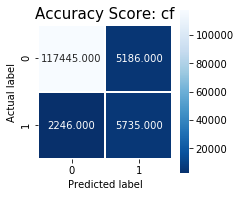

In [70]:
utils.evaluation_metrics(cf,'test')

In [71]:
# f1 scores on diffrent thersholds
prob_array=np.sort(1*np.random.random(15))

for i in prob_array:
    df_test['pred_label']=(df_test['pred_prob']>i).astype(int)
    f1=f1_score(df_test['target'],df_test['pred_label'])
    print('thershold: ',i,' f1_score: ',f1)

thershold:  0.038808342041987576  f1_score:  0.3014815982346915
thershold:  0.054615797253002696  f1_score:  0.3390043825148893
thershold:  0.0576358920485911  f1_score:  0.34553964757709255
thershold:  0.05838149379553115  f1_score:  0.3470940959409594
thershold:  0.08698553709582224  f1_score:  0.39621630312449757
thershold:  0.14029012800138962  f1_score:  0.4569020559315541
thershold:  0.2397650958937506  f1_score:  0.5303326810176126
thershold:  0.3431816911511111  f1_score:  0.5745950554134697
thershold:  0.37506990454995937  f1_score:  0.5841390851617702
thershold:  0.44731257400203606  f1_score:  0.5994092024232714
thershold:  0.6147835549031895  f1_score:  0.6128449210748282
thershold:  0.6371260542379299  f1_score:  0.6094399305340197
thershold:  0.7380451977891601  f1_score:  0.5600644594198653
thershold:  0.7424032676860891  f1_score:  0.5560968408621199
thershold:  0.7861506104507859  f1_score:  0.5114664082687339


In [72]:
# making probaility bins
df_test['pred_label']=model.predict_classes(test_X)
df_analysis=copy.deepcopy(df_test)
df_analysis=df_analysis.sort_values(by='pred_prob').reset_index(drop=True)
df_analysis['index']=df_analysis.index
df_analysis['bins']= pd.cut(x=df_analysis['index'],bins=20)

df_ana=df_analysis.groupby('bins').agg({'target':'count'}).rename({'target':'count'},axis=1).reset_index()
df_ana['no_default']=np.array(df_analysis.groupby('bins').agg({'target':'sum'}))
df_ana['min_prob']=np.array(df_analysis.groupby('bins').agg({'pred_prob':'min'})['pred_prob'])
df_ana['max_prob']=np.array(df_analysis.groupby('bins').agg({'pred_prob':'max'})['pred_prob'])
df_ana['%default']=np.array(df_analysis.groupby('bins').agg({'target':'mean'})*100)
df_ana['bins']=df_ana.index      
df_ana

,bins,count,no_default,min_prob,max_prob,%default
0,0,6531,4,0.000,0.000,0.061
1,1,6531,6,0.000,0.001,0.092
2,2,6530,6,0.001,0.001,0.092
3,3,6531,8,0.001,0.002,0.122
4,4,6530,6,0.002,0.003,0.092
5,5,6531,19,0.003,0.005,0.291
6,6,6530,19,0.005,0.006,0.291
7,7,6531,18,0.006,0.008,0.276
8,8,6530,24,0.008,0.011,0.368
9,9,6531,31,0.011,0.014,0.475


In [73]:
df_wrong=df_analysis.loc[df_analysis['pred_label']!=df_analysis['target']].reset_index(drop=True)
df_correct=df_analysis.loc[df_analysis['pred_label']==df_analysis['target']].reset_index(drop=True)

### correct classification analysis

In [74]:
correct_pred_as_0=df_correct.iloc[0:5,:]
correct_pred_as_0

,question_text,target,raw_question_text,pred_label,pred_prob,index,bins
0,loss pay days banks national holiday national ...,0,What if in loss of pay of 7 days in banks a na...,0,0.000,0,"(-130.611, 6530.55]"
1,placements solid mechanics design iit kanpur a...,0,How are placements of Solid Mechanics & Design...,0,0.000,1,"(-130.611, 6530.55]"
2,happen thermal switch newer gas water heaters ...,0,What can happen when the thermal switch on new...,0,0.000,2,"(-130.611, 6530.55]"
3,boyfriend still messages ex almost everyday sa...,0,My boyfriend still messages his ex almost ever...,0,0.000,3,"(-130.611, 6530.55]"
4,deck cards dealt four hands containing cards o...,0,A deck of cards is dealt into four hands conta...,0,0.000,4,"(-130.611, 6530.55]"


In [75]:
k=1
for i in correct_pred_as_0['raw_question_text']:
    print(k,'> ',i)
    print()
    k+=1

1 >  What if in loss of pay of 7 days in banks a national holiday is between, the national holiday will also be calculated as loss of pay?

2 >  How are placements of Solid Mechanics & Design at IIT Kanpur? Also, please compare the placements with mechanical Design @ IIT Madras if one knows?

3 >  What can happen when the thermal switch on newer gas water heaters is bypassed with a wire nut? I see this everywhere in apartments and nobody seems to think it’s an issue.

4 >  My boyfriend still messages his ex almost everyday and he says they're just friends. How do I deal with the insecurities I'm having right now?

5 >  A deck of cards is dealt into four hands containing 13 cards each. If one hand has exactly eight spades, what is the probability that a particular one of the other hands has (a) at least one spade? (b) at least two spades? (c) a complete suit?



In [76]:
correct_pred_as_1=df_correct.iloc[-6:-1,:] 
correct_pred_as_1

,question_text,target,raw_question_text,pred_label,pred_prob,index,bins
123174,quora full liberal whiny bitches,1,Why is Quora so full of liberal whiny bitches?,1,0.986,130606,"(124080.45, 130611.0]"
123175,instagram nri indian feminists hypocrites,1,"Why are all these instagram NRI ""Indian"" femin...",1,0.987,130607,"(124080.45, 130611.0]"
123176,left wing liberals condescending demeaning,1,Are left wing liberals condescending and demea...,1,0.988,130608,"(124080.45, 130611.0]"
123177,fact white women raped black men chattel slave...,1,Why is the fact that white women raped black m...,1,0.988,130609,"(124080.45, 130611.0]"
123178,black guys dicks much bigger white guys,1,Why are black guys dicks so much bigger than w...,1,0.990,130610,"(124080.45, 130611.0]"


In [77]:
k=1
for i in correct_pred_as_1['raw_question_text']:
    print(k,'> ',i)
    print()
    k+=1

1 >  Why is Quora so full of liberal whiny bitches?

2 >  Why are all these instagram NRI "Indian" feminists such hypocrites?

3 >  Are left wing liberals condescending and demeaning?

4 >  Why is the fact that white women raped black men during chattel slavery never brought up?

5 >  Why are black guys dicks so much bigger than white guys?



### wrong classification analysis

In [78]:
wrong_pred_as_0=df_wrong.iloc[0:5,:]
wrong_pred_as_0

,question_text,target,raw_question_text,pred_label,pred_prob,index,bins
0,empty nesters complain bad let spend day two c...,1,Why do empty nesters complain about how bad it...,0,0.000,993,"(-130.611, 6530.55]"
1,components xl test plus,1,What are the components of the XL Test Plus?,0,0.000,4339,"(-130.611, 6530.55]"
2,tips exercising white privilege,1,What are some tips for exercising my white pri...,0,0.000,6404,"(-130.611, 6530.55]"
3,evaluate integral mathdisplaystyle int oint in...,1,How do you evaluate this integral: [math]\disp...,0,0.000,6481,"(-130.611, 6530.55]"
4,paladins similar overwatch,1,Is Paladins similar to Overwatch?,0,0.001,10165,"(6530.55, 13061.1]"


In [79]:
# printing sentence by sentence
k=1
for i in wrong_pred_as_0['raw_question_text']:
    print(k,'> ',i)
    print()
    k+=1

1 >  Why do empty nesters complain about how bad it is? Let them spend a day with my two children under 5 years old.

2 >  What are the components of the XL Test Plus?

3 >  What are some tips for exercising my white privilege?

4 >  How do you evaluate this integral: [math]\displaystyle \int_0 \oint \int^1 \underbrace{(x^2+2x+1)}_{\text{Factor This...}} \sin(x^2) dx^3[/math]?

5 >  Is Paladins similar to Overwatch?



In [80]:
wrong_pred_as_1=df_wrong.iloc[-6:-1,:] 
wrong_pred_as_1

,question_text,target,raw_question_text,pred_label,pred_prob,index,bins
7426,black people always say black people cant raci...,0,Why do Black people always say Black people ca...,1,0.971,130561,"(124080.45, 130611.0]"
7427,psychopathssociopaths find stupid questions ob...,0,Do psychopaths/sociopaths find stupid question...,1,0.973,130577,"(124080.45, 130611.0]"
7428,black people scared white people,0,Are black people scared of white people?,1,0.975,130587,"(124080.45, 130611.0]"
7429,explain feminists hating women doesnt make sexist,0,How do I explain to feminists that hating wome...,1,0.977,130593,"(124080.45, 130611.0]"
7430,dab haters haters dab back,0,What should I do when I dab on the haters but ...,1,0.983,130604,"(124080.45, 130611.0]"


In [81]:
# printing sentence by sentence
k=1
for i in wrong_pred_as_1['raw_question_text']:
    print(k,'> ',i)
    print()
    k+=1

1 >  Why do Black people always say Black people can't be racist, when there are attacks by black people from South Africa which attacks immigrants?

2 >  Do psychopaths/sociopaths find stupid questions obnoxious? If I'm annoyed by a stupid question am I a psychopath? I'm seeing a ton more stupid questions about psychopaths and they really annoy me, am I a psychopath?

3 >  Are black people scared of white people?

4 >  How do I explain to feminists that hating women doesn't make me sexist?

5 >  What should I do when I dab on the haters but the haters dab back?

